### Training an image classifier  
1. Load and normalize MNIST 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Let us show some of the training images, for fun.



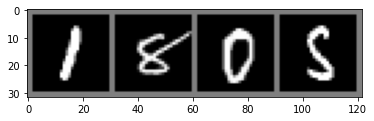

Labels: [1, 8, 0, 5]


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:', labels.tolist())

<div> 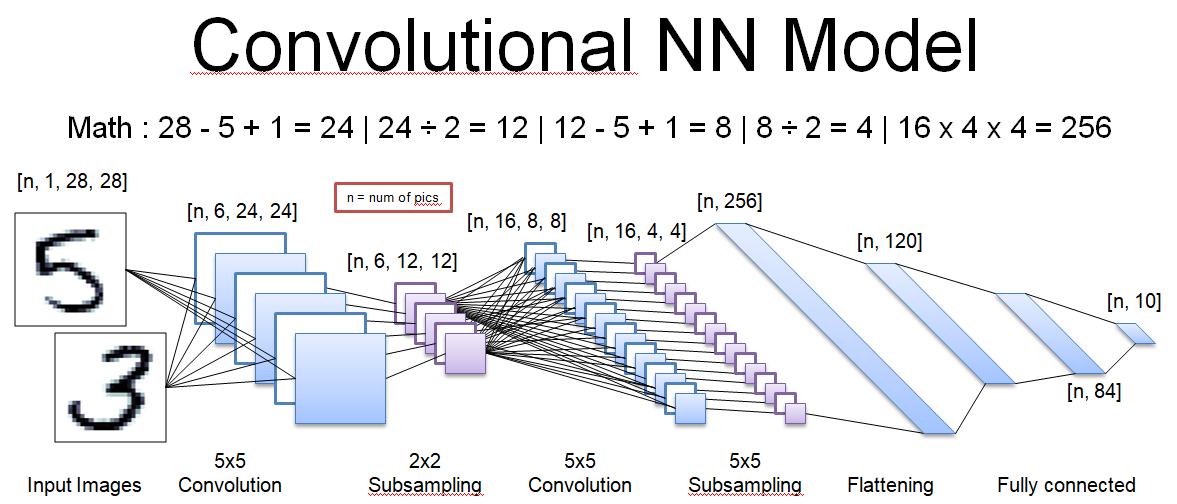 </div>

2. Define a Convolutional Neural Network

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools

class Net(nn.Module): 
    def __init__(self, debug=False):
        super(Net, self).__init__()
        # It is a grayscale picture so only one input channel (in_channels=1)
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        # We don't need tell conv layers shape of input tensor 
        self.c2 = nn.Conv2d(6, 16, 5)
        # But the problem is following linear layers need the right tensor shape
        self.l1 = nn.Linear(16 * 4 * 4, 120)
        self.l2 = nn.Linear(120, 84)
        self.l3 = nn.Linear(84, 10)
        if debug: # print learnable parameters
            params = list(self.parameters())
            print(params[0])  # c1's Weight Matrix
            print(params[1])  # c1's Bias   Matrix

    def forward(self, x):
        # Convolution 
        x = self.c1(x)                    # x.shape (n, 1, 28, 28)  --> (n,  6, 24, 24)  
        x = F.relu(x)
        
        # Subsampling
        x = F.max_pool2d(x, (2, 2))       # x.shape (n, 6, 24, 24)  --> (n, 16, 12, 12) 
        
        # Convolution
        x = self.c2(x)                    # x.shape (n, 16, 12, 12) --> (n, 16, 8, 8)  
        x = F.relu(x)
        
        # Subsampling 
        x = F.max_pool2d(x, 2)            # x.shape (n, 16, 8, 8) --> (n, 16, 4, 4) 
       
        # Flattening  
        nof = functools.reduce(lambda i, j: i*j, x.shape[1:]) 
        x = x.view(-1, nof)               # x.shape (n, 16, 4, 4)   --> (n, 256) 
       
        # Full connection
        x = self.l1(x)                    # x.shape (n, 256)        --> (n, 120) 
        x = F.relu(x)
        
        # Full connection
        x = self.l2(x)                    # x.shape (n, 120)        --> (n, 84) 
        x = F.relu(x)
        
        # Full connection
        x = self.l3(x)                    # x.shape (n, 84)         --> (n, 10) 
        return x 

net = Net()

3. Define a Loss function and optimizer 

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network 

In [5]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Draw new DAG
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # zero the gradient parameters + backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.331
[1,  4000] loss: 0.203
[1,  6000] loss: 0.137
[1,  8000] loss: 0.108
[1, 10000] loss: 0.104
[1, 12000] loss: 0.076
[1, 14000] loss: 0.089
[2,  2000] loss: 0.057
[2,  4000] loss: 0.066
[2,  6000] loss: 0.057
[2,  8000] loss: 0.060
[2, 10000] loss: 0.054
[2, 12000] loss: 0.057
[2, 14000] loss: 0.049
Finished Training


Let's quickly save our trained model:



In [6]:
PATH = './data/mnist_net.pth'
torch.save(net.state_dict(), PATH)
list(net.parameters())[1].tolist()

[-0.35851675271987915,
 0.021478159353137016,
 -0.030245035886764526,
 0.17794311046600342,
 -0.20513205230236053,
 0.31851711869239807]

We printed bias vector of first convolutional layer<br>
We will test if this bias vector could be read into a new model

In [7]:
net = Net()
list(net.parameters())[1].tolist()

[0.024699807167053223,
 0.09283111244440079,
 0.04814205318689346,
 0.11990457028150558,
 -0.17525699734687805,
 -0.13782809674739838]

See, new Net() instance comes with a new randomly initialized bias vector<br>
We will load the old weighs and biases

In [8]:
net.load_state_dict(torch.load(PATH))
list(net.parameters())[1].tolist()

[-0.35851675271987915,
 0.021478159353137016,
 -0.030245035886764526,
 0.17794311046600342,
 -0.20513205230236053,
 0.31851711869239807]

See, the old parameters are back

5. Test the network on the test data 

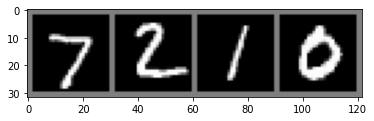

GroundTruth:  [7, 2, 1, 0]
Predicted:  [7, 2, 1, 0]


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', labels.tolist())

outputs = net(images) 
_, predicted = torch.max(outputs, 1) 
print('Predicted: ', predicted.tolist())

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %
